# Jianjin008 Dataset Processing


In [ ]:
import os
import random
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import shutil

In [ ]:
# ================== CONFIG ==================
import os
from google.colab import drive
drive.mount('/content/drive')

# Install pv for progress visualization
!apt-get -qq install unrar pv

# Clean destination (no longer needed as we are unzipping directly to drive)
# !rm -rf /content/jianjin008
# !mkdir -p /content/jianjin008

# Quiet unzip into the final drive folder, overriding existing files
!unzip -q -o "/content/drive/MyDrive/Samsung_Datasets/jianjin008.zip" -d "/content/drive/MyDrive/Samsung_Project/jianjin008"

DATASET_PATH = "/content/drive/MyDrive/Samsung_Project/jianjin008/icip"
REF_PATH = os.path.join(DATASET_PATH, "ref_img")
DIST_PATH = os.path.join(DATASET_PATH, "jnd_img")
MOS_FILE = os.path.join(DATASET_PATH, "mos.txt")
OUTPUT_PATH = "/content/jianjin008_patches" # Keep local for processing speed
PATCHES_DIR = os.path.join(OUTPUT_PATH, "patches")

NUM_SAMPLES = 1000
PATCH_SIZE = 20
CENTER_SIZE = 12
ALPHA = 0.5

os.makedirs(PATCHES_DIR, exist_ok=True)
# The rsync command is no longer needed as we are unzipping directly to the final structure
# !rsync -a /content/jianjin008_raw/icip/ /content/jianjin008/

# Check that the structure is now flattened (check the drive path)
!ls -R "/content/drive/MyDrive/Samsung_Project/jianjin008/icip" | head -20

Mounted at /content/drive
Selecting previously unselected package pv.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../pv_1.6.6-1build2_amd64.deb ...
Unpacking pv (1.6.6-1build2) ...
Setting up pv (1.6.6-1build2) ...
Processing triggers for man-db (2.10.2-1) ...
/content/drive/MyDrive/Samsung_Project/jianjin008/icip:
jnd_img
mos.txt
paper.pdf
README.txt
ref_img
test_metadata.json
train_metadata.json

/content/drive/MyDrive/Samsung_Project/jianjin008/icip/jnd_img:
I01_02_01.png
I01_06_01.png
I01_08_01.png
I01_09_01.png
I01_10_01.png
I01_16_01.png
I01_16_02.png
I01_17_01.png
I01_17_02.png
I01_19_01.png


In [ ]:
# ================== LOAD MOS ==================
def load_mos_with_names(mos_file):
    mos_dict = {}
    with open(mos_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                # check if the first part looks like a filename (contains a dot)
                if "." in parts[0]:
                    fname, score = parts
                else:
                    score, fname = parts
                try:
                    mos_dict[fname] = float(score)
                except ValueError:
                    print(f"Could not convert score to float for line: {line.strip()}")
                    continue
    return mos_dict

In [ ]:
# ================== HELPERS ==================
def compute_psnr(img1, img2):
    arr1, arr2 = np.array(img1, dtype=np.float32), np.array(img2, dtype=np.float32)
    mse = np.mean((arr1 - arr2) ** 2)
    if mse == 0:
        return float("inf")
    return 10 * np.log10((255 ** 2) / mse)

def extract_patch(img, x, y, size=20):
    return img.crop((x, y, x + size, y + size))

def fuse_patch(clean_patch, dist_patch, mode="blend", alpha=0.5):
    clean_arr = np.array(clean_patch).astype(np.float32)
    dist_arr = np.array(dist_patch).astype(np.float32)
    h, w, _ = clean_arr.shape
    cx, cy = w // 2, h // 2
    half = CENTER_SIZE // 2
    x1, y1 = cx - half, cy - half
    x2, y2 = x1 + CENTER_SIZE, y1 + CENTER_SIZE

    fused = dist_arr.copy()
    if mode == "copy":
        fused[y1:y2, x1:x2] = clean_arr[y1:y2, x1:x2]

    return Image.fromarray(np.uint8(fused))

## Checking how many images there are:

In [ ]:
# ================== LOAD AND SELECT FILES ==================
# Load MOS data
mos_dict = load_mos_with_names(MOS_FILE)

# Select files to process (e.g., all files with MOS scores)
selected_files = list(mos_dict.keys())

# Optionally, limit the number of files for testing
# selected_files = selected_files[:NUM_SAMPLES]

print(f"Loaded MOS data for {len(mos_dict)} files.")
print(f"Selected {len(selected_files)} files for processing.")

Loaded MOS data for 1641 files.
Selected 1641 files for processing.


## Checking how many combinations of images with the same distortion type there are:

In [ ]:
from collections import defaultdict
from collections import Counter

# Dictionary to store distortion levels per image and distortion type
distortion_levels_per_image_type = defaultdict(lambda: defaultdict(set))
filtered_distortion_levels = []
filtered_distortion_types = []

num = 0

if os.path.exists(MOS_FILE):
    try:
        with open(MOS_FILE, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:
                    filename = parts[0]
                    # Extract image number, distortion type, and level from the filename
                    # Filename format: IXX_YY_Z.png or IXX_YY_Z.bmp
                    filename_parts = filename.split('_')
                    if len(filename_parts) >= 3:
                        image_number = filename_parts[0] # e.g., I17
                        distortion_type = filename_parts[1] # e.g., 05
                        distortion_level = filename_parts[2].split('.')[0] # e.g., 01, 02, 03
                        distortion_levels_per_image_type[image_number][distortion_type].add(distortion_level)
                    else:
                        print(f"Skipping line with unexpected filename format: {line.strip()}")

        if distortion_levels_per_image_type:
            # Sort by image number and then distortion type for consistent output
            sorted_images = sorted(distortion_levels_per_image_type.keys())
            for image_number in sorted_images:
                sorted_distortion_types = sorted(distortion_levels_per_image_type[image_number].keys())
                for distortion_type in sorted_distortion_types:
                    levels = sorted(list(distortion_levels_per_image_type[image_number][distortion_type])) # Sort levels numerically
                    # Filter to only include those with 3 or more distortion levels
                    if len(levels) >= 3:
                        filtered_distortion_levels.extend(levels)
                        filtered_distortion_types.extend([distortion_type] * len(levels))
                        num = num + 1

            print(f"\nTotal number of unique image and distortion type combinations with 3+ levels: {num}")

        else:
            print(f"No valid filenames found in {MOS_FILE} to extract distortion information.")

    except Exception as e:
        print(f"An error occurred while processing {MOS_FILE}: {e}")

else:
    print(f"File '{MOS_FILE}' not found.")


Total number of unique image and distortion type combinations with 3+ levels: 121


## How many images there are in total that do not fit the theory of slight_flicker + no_flicker

In [ ]:
# ================== FILTER FILES ==================
# Create a set of filenames to exclude based on the previous analysis
excluded_filenames = set()
if distortion_levels_per_image_type:
    for image_number, distortion_types in distortion_levels_per_image_type.items():
        for distortion_type, levels in distortion_types.items():
            # Filter to only include those with 3 or more distortion levels
            if len(levels) >= 3:
                # Construct the filenames to exclude for this image_number and distortion_type
                for level in levels:
                    # Assuming the format is always IXX_YY_Z.png or IXX_YY_Z.bmp
                    # Need to check both .png and .bmp extensions
                    excluded_filenames.add(f"{image_number}_{distortion_type}_{level}.png")
                    excluded_filenames.add(f"{image_number}_{distortion_type}_{level}.bmp")

# Filter the selected_files list
original_selected_files_count = len(selected_files)
selected_files = [fname for fname in selected_files if fname not in excluded_filenames]

print(f"Original number of selected files: {original_selected_files_count}")
print(f"Number of files excluded (with 3+ distortion levels): {original_selected_files_count - len(selected_files)}")
print(f"Number of files remaining after filtering: {len(selected_files)}")

Original number of selected files: 1641
Number of files excluded (with 3+ distortion levels): 375
Number of files remaining after filtering: 1266


In [ ]:
# ================== CATEGORIZE FILES BASED ON MOS SCORE PAIRS ==================
no_flicker = []
slight_flicker = []
same_score = [] # This list will now also include files generated by blending

# Create a dictionary to group files by their base image and distortion type
# This will help in pairing the images with different distortion levels
file_groups = defaultdict(list)
for fname in selected_files:
    parts = fname.split('_')
    if len(parts) >= 3:
        # Use image number and distortion type as the key for grouping
        base_name = f"{parts[0]}_{parts[1]}"
        file_groups[base_name].append(fname)
    else:
        print(f"Skipping {fname} due to unexpected filename format for grouping.")


# Iterate through the grouped files and compare MOS scores for pairs
for base_name, files in file_groups.items():
    # Assuming that files with the same base_name and distortion type form a pair
    # We can process them in pairs of two. If there's an odd number, the last one is added to slight_flicker.
    files.sort() # Sort to ensure consistent pairing if needed, though not strictly necessary for this logic
    for i in range(0, len(files), 2):
        if i + 1 < len(files):
            file1 = files[i]
            file2 = files[i+1]

            mos1 = mos_dict.get(file1)
            mos2 = mos_dict.get(file2)

            if mos1 is None or mos2 is None:
                print(f"Skipping pair ({file1}, {file2}) due to missing MOS score.")
                continue

            if mos1 < mos2:
                no_flicker.append(file1)
                slight_flicker.append(file2)
            elif mos2 < mos1:
                no_flicker.append(file2)
                slight_flicker.append(file1)
            else:
                # If MOS scores are the same, add both files to the same_score list
                same_score.append(file1)
                same_score.append(file2)

                # Additionally, create a 'blended' representation and add its filename to same_score
                # This assumes you will generate blended images later based on this list.
                # For now, we just add a placeholder filename.
                blended_fname = f"blended_{file1}" # Create a unique name for the blended image
                same_score.append(blended_fname)

        else:  # This handles the case of an unpaired file
             slight_flicker.append(files[i])

print(f"Number of files in 'no_flicker' list: {len(no_flicker)}")
print(f"Number of files in 'slight_flicker' list: {len(slight_flicker)}")
print(f"Number of files in 'same_score' list: {len(same_score)}")

Number of files in 'no_flicker' list: 254
Number of files in 'slight_flicker' list: 966
Number of files in 'same_score' list: 69


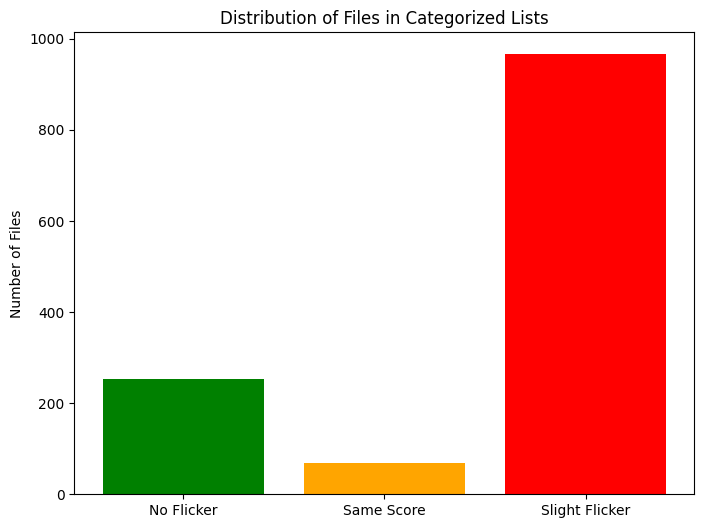

In [ ]:
import matplotlib.pyplot as plt

# Create a list of the lengths of the lists
list_counts = [len(no_flicker), len(same_score), len(slight_flicker)]
list_labels = ['No Flicker', 'Same Score', 'Slight Flicker']

plt.figure(figsize=(8, 6))
plt.bar(list_labels, list_counts, color=['green', 'orange', 'red'])
plt.ylabel('Number of Files')
plt.title('Distribution of Files in Categorized Lists')
plt.show()

## Now lets try to even out the lists.
### first take the no flicker + slight flicker and create more same_score images. now tjere will be the same amount of same_score and no_flicker - still the slight_flicker is very high

In [ ]:
# ================== MAIN LOOP (INTEGRATED BLENDING) ==================
import random
metadata = []
psnr_values = []

DATASET_NAME = "jianjin008"
processed_files_count = 0 # Counter for all processed patches (original and blended)

# Combine the lists for easier iteration (excluding same_score for initial processing)
files_to_process_no_blend = no_flicker + slight_flicker

# Process files that are not blended (copy method)
print("Processing original patches (copy method)...")
for idx, fname in enumerate(files_to_process_no_blend):
    # Determine the category of the current file
    chosen_category = None
    if fname in no_flicker:
        chosen_category = "GREEN"
    elif fname in slight_flicker:
        chosen_category = "RED"
    else:
        # This case should theoretically not be reached
        print(f"Skipping {fname}, not found in no_flicker or slight_flicker.")
        continue

    # Parse distorted filename
    parts = fname.lower().split("_")
    if len(parts) < 3:
        print(f"Skipping {fname}, invalid filename format")
        continue

    ref_id = parts[0].upper()

    # ----- Reference lookup -----
    clean_file = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(REF_PATH, f"{ref_id}{ext}")
        if os.path.exists(candidate):
            clean_file = candidate
            break
    if clean_file is None:
        # print(f"Skipping {fname}, reference not found at {REF_PATH}")
        continue

    # ----- Distorted lookup -----
    dist_file = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(DIST_PATH, os.path.splitext(fname)[0] + ext)
        if os.path.exists(candidate):
            dist_file = candidate
            break
    if dist_file is None:
        print(f"Skipping {fname}, distorted not found at {DIST_PATH}")
        continue

    # ----- Load images -----
    try:
        clean_img = Image.open(clean_file).convert("RGB")
        dist_img = Image.open(dist_file).convert("RGB")
    except Exception as e:
        print(f"Error loading images for {fname}: {e}. Skipping.")
        continue

    # Calculate PSNR of the distorted image relative to the clean image
    dist_psnr = compute_psnr(clean_img, dist_img)

    w, h = clean_img.size

    # Check if image size is large enough for patching
    if w < PATCH_SIZE or h < PATCH_SIZE:
        print(f"Skipping {fname}, image too small for patching ({w}x{h}).")
        continue

    # Random coords
    x = random.randint(0, w - PATCH_SIZE)
    y = random.randint(0, h - PATCH_SIZE)

    clean_patch = extract_patch(clean_img, x, y, PATCH_SIZE)
    dist_patch = extract_patch(dist_img, x, y, PATCH_SIZE)

    # ----- Generate ref patches (copy fusion) -----
    fusion_mode = "copy"
    method_label = "copy"

    fused_patch = fuse_patch(clean_patch, dist_patch, mode=fusion_mode, alpha=ALPHA)
    psnr = compute_psnr(clean_patch, fused_patch)
    psnr_values.append(psnr)

    out_name = f"{method_label}_patch_{processed_files_count:04}.png"
    fused_patch.save(os.path.join(PATCHES_DIR, out_name))

    # Get MOS
    mos_score = mos_dict.get(fname)
    if mos_score is None:
        print(f"Warning: MOS score not found for {fname}. Skipping metadata.")
        continue

    normalized_score = round(mos_score / 9, 3)

    # Assign color and binned_score
    color = chosen_category # GREEN or RED
    binned_score = 1 if chosen_category == "GREEN" else 0

    dist_id  = os.path.splitext(os.path.basename(dist_file))[0]
    uid = out_name

    # Build metadata entry
    metadata.append({
      "unique_sample_id": uid,
      "clean_image": os.path.basename(clean_file),
      "distorted_image": os.path.basename(dist_file),
      "score": float(normalized_score),
      "metadata": {
        "method": method_label,
        "image_source": DATASET_NAME,
        "bp_case": f"case{distortion_type}",
        "color": color,
        "score_binned": binned_score,
        "IQE_workspace_number": 990,
        "mos_original": mos_score,
        "mos_normalized": normalized_score,
        "roi": [x, y, PATCH_SIZE, PATCH_SIZE],
        "crop_id": dist_id,
        "distorted_psnr": dist_psnr
      }
    })
    processed_files_count += 1


# Identify blending pairs from no_flicker and slight_flicker
blending_candidates = defaultdict(lambda: defaultdict(list))

for fname in no_flicker:
    parts = fname.split('_')
    if len(parts) >= 2:
        base_name = f"{parts[0]}_{parts[1]}"
        blending_candidates[base_name]['no_flicker'].append(fname)

for fname in slight_flicker:
    parts = fname.split('_')
    if len(parts) >= 2:
        base_name = f"{parts[0]}_{parts[1]}"
        blending_candidates[base_name]['slight_flicker'].append(fname)

blending_pairs = []
for base_name, categories in blending_candidates.items():
    no_flicker_files = categories.get('no_flicker', [])
    slight_flicker_files = categories.get('slight_flicker', [])
    if no_flicker_files and slight_flicker_files:
        blending_pairs.append((no_flicker_files[0], slight_flicker_files[0])) # Take the first one from each

print(f"\nProcessing {len(blending_pairs)} blending pairs...")

# Process blending pairs (blend method)
for file1, file2 in blending_pairs:
    # Parse filenames to find the common reference image
    parts1 = file1.split('_')
    parts2 = file2.split('_')

    if len(parts1) < 2 or len(parts2) < 2 or parts1[0] != parts2[0]:
        print(f"Skipping pair ({file1}, {file2}) due to inconsistent format or different ref images.")
        continue

    ref_id = parts1[0].upper()
    distortion_type = parts1[1] # Assuming distortion type is same for the pair

    # ----- Reference lookup -----
    clean_file = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(REF_PATH, f"{ref_id}{ext}")
        if os.path.exists(candidate):
            clean_file = candidate
            break
    if clean_file is None:
        print(f"Skipping pair ({file1}, {file2}), reference not found at {REF_PATH}")
        continue

    # ----- Distorted lookup for both files -----
    dist_file1 = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(DIST_PATH, os.path.splitext(file1)[0] + ext)
        if os.path.exists(candidate):
            dist_file1 = candidate
            break

    dist_file2 = None
    for ext in [".BMP", ".bmp", ".PNG", ".png"]:
        candidate = os.path.join(DIST_PATH, os.path.splitext(file2)[0] + ext)
        if os.path.exists(candidate):
            dist_file2 = candidate
            break

    if dist_file1 is None or dist_file2 is None:
        print(f"Skipping pair ({file1}, {file2}), one or both distorted images not found at {DIST_PATH}")
        continue

    # ----- Load images -----
    try:
        dist_img1 = Image.open(dist_file1).convert("RGB")
        dist_img2 = Image.open(dist_file2).convert("RGB")
    except Exception as e:
        print(f"Error loading images for pair ({file1}, {file2}): {e}. Skipping.")
        continue

    w, h = dist_img1.size # Assuming both distorted images have same size

    # Check if image size is large enough for patching
    if w < PATCH_SIZE or h < PATCH_SIZE:
        print(f"Skipping pair ({file1}, {file2}), image too small for patching ({w}x{h}).")
        continue

    # ----- Extract and Blend Patches -----
    # Generate random coordinates (same for both distorted images)
    x = random.randint(0, w - PATCH_SIZE)
    y = random.randint(0, h - PATCH_SIZE)

    dist_patch1 = extract_patch(dist_img1, x, y, PATCH_SIZE)
    dist_patch2 = extract_patch(dist_img2, x, y, PATCH_SIZE)

    # Convert patches to NumPy arrays (float32 for blending)
    dist_arr1 = np.array(dist_patch1, dtype=np.float32)
    dist_arr2 = np.array(dist_patch2, dtype=np.float32)

    # Create blended patch by averaging the two distorted patches
    blended_arr = (dist_arr1 + dist_arr2) / 2.0

    # Convert back to PIL Image (uint8 for saving)
    blended_patch = Image.fromarray(np.uint8(np.clip(blended_arr, 0, 255)))

    # Calculate average MOS for the blended patch
    mos1 = mos_dict.get(file1)
    mos2 = mos_dict.get(file2)
    average_mos = (mos1 + mos2) / 2.0 if mos1 is not None and mos2 is not None else None

    if average_mos is None:
        print(f"Warning: MOS score missing for one or both files in pair ({file1}, {file2}). Skipping metadata for blended patch.")
        continue

    normalized_average_mos = round(average_mos / 9, 3)

    method_label = "blended"
    out_name = f"{method_label}_patch_{processed_files_count:04}.png"
    blended_patch.save(os.path.join(PATCHES_DIR, out_name))

    uid = out_name

    # Build metadata entry for the blended patch
    metadata.append({
      "unique_sample_id": uid,
      "clean_image": os.path.basename(clean_file), # Assuming clean image is same for both
      "distorted_image_1": os.path.basename(file1),
      "distorted_image_2": os.path.basename(file2),
      "score": float(normalized_average_mos),
      "metadata": {
        "method": method_label,
        "image_source": DATASET_NAME,
        "bp_case": f"case{distortion_type}",
        "color": "ORANGE", # Assign 'ORANGE' for blended patches
        "score_binned": 0.5, # Assign 0.5 for blended patches
        "IQE_workspace_number": 990,
        "mos_original_1": mos1,
        "mos_original_2": mos2,
        "mos_average": float(average_mos),
        "mos_normalized": float(normalized_average_mos),
        "roi": [x, y, PATCH_SIZE, PATCH_SIZE],
        "crop_id": f"{os.path.splitext(file1)[0]}_{os.path.splitext(file2)[0]}",
        # PSNR for blended patch relative to clean patch would require loading clean patch here
        # For simplicity, we omit blended_psnr for now or could calculate if needed
      }
    })
    processed_files_count += 1


# Print the total number of patches created
print(f"\nTotal number of patches created: {processed_files_count}")

Processing original patches (copy method)...
Skipping I33_17_02.png, distorted not found at /content/drive/MyDrive/Samsung_Project/jianjin008/icip/jnd_img

Processing 254 blending pairs...

Total number of patches created: 1473


## Now to finally even it out - lets drop "red" images to match the amount of other two categories. If not, the dataset will be biased towards the "red" images.

In [ ]:
# --- Added for balancing after patch generation ---
from collections import Counter
import random

# Count patches by color category from metadata AFTER the main loop has run
color_counts = Counter(entry.get("metadata", {}).get("color") for entry in metadata if entry.get("metadata", {}).get("color") in ["GREEN", "ORANGE", "RED"])

green_count = color_counts.get("GREEN", 0)
orange_count = color_counts.get("ORANGE", 0)
red_count = color_counts.get("RED", 0)

print(f"Patch counts before post-generation balancing: GREEN={green_count}, ORANGE={orange_count}, RED={red_count}")

# Determine the target size based on the minimum of GREEN and ORANGE counts
# Assuming the goal is to balance all three to the size of the smallest of GREEN/ORANGE.
target_size = min(green_count, orange_count)

# Reconstruct the 'slight_flicker' list based on the metadata of generated RED patches
current_slight_flicker_filenames = [
    entry["distorted_image"] for entry in metadata
    if entry.get("metadata", {}).get("color") == "RED"
]

if len(current_slight_flicker_filenames) > target_size:
    # Sample the filenames
    balanced_slight_flicker_filenames = random.sample(current_slight_flicker_filenames, target_size)

    # Identify the unique sample IDs for the RED patches
    red_patch_uids = [entry["unique_sample_id"] for entry in metadata if entry.get("metadata", {}).get("color") == "RED"]

    if len(red_patch_uids) > target_size:
        # Randomly select the UIDs to keep
        uids_to_keep = set(random.sample(red_patch_uids, target_size))

        # Create a new metadata list containing only the patches we want to keep
        balanced_metadata = []
        removed_patch_uids = set()
        for entry in metadata:
            if entry.get("metadata", {}).get("color") == "RED":
                if entry["unique_sample_id"] in uids_to_keep:
                    balanced_metadata.append(entry)
                else:
                    # Track removed UIDs to potentially delete patch files later if needed
                    removed_patch_uids.add(entry["unique_sample_id"])
            else:
                # Keep GREEN and ORANGE patches
                balanced_metadata.append(entry)

        # Replace the original metadata list with the balanced one
        metadata = balanced_metadata
        print(f"Reduced number of RED patches in metadata to {target_size} by sampling.")
        # Note: The actual patch files in the output directory are not deleted by this step.
        # If physical file removal is needed, that would be a separate step using removed_patch_uids.

# Re-count patches by color category from the potentially balanced metadata
color_counts_after = Counter(entry.get("metadata", {}).get("color") for entry in metadata if entry.get("metadata", {}).get("color") in ["GREEN", "ORANGE", "RED"])

print(f"Patch counts after post-generation balancing (in metadata): GREEN={color_counts_after.get('GREEN', 0)}, ORANGE={color_counts_after.get('ORANGE', 0)}, RED={color_counts_after.get('RED', 0)}")

# --- End Added for balancing after patch generation ---

Patch counts before post-generation balancing: GREEN=254, ORANGE=254, RED=965
Reduced number of RED patches in metadata to 254 by sampling.
Patch counts after post-generation balancing (in metadata): GREEN=254, ORANGE=254, RED=254


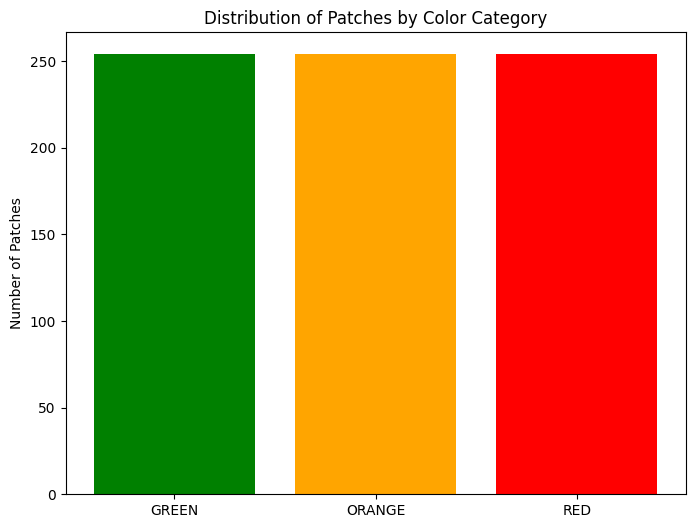

In [ ]:
# ================== DISPLAY PATCH COUNTS BY COLOR (BAR CHART) ==================
from collections import Counter
import matplotlib.pyplot as plt

# Count patches by color category from metadata
color_counts = Counter(entry.get("metadata", {}).get("color") for entry in metadata if entry.get("metadata", {}).get("color") in ["GREEN", "ORANGE", "RED"])

# Create lists for labels and counts for plotting
list_labels = list(color_counts.keys())
list_counts = list(color_counts.values())

# Ensure consistent order for plotting
ordered_labels = ["GREEN", "ORANGE", "RED"]
ordered_counts = [color_counts.get(label, 0) for label in ordered_labels]

plt.figure(figsize=(8, 6))
plt.bar(ordered_labels, ordered_counts, color=['green', 'orange', 'red'])
plt.ylabel('Number of Patches')
plt.title('Distribution of Patches by Color Category')
plt.show()

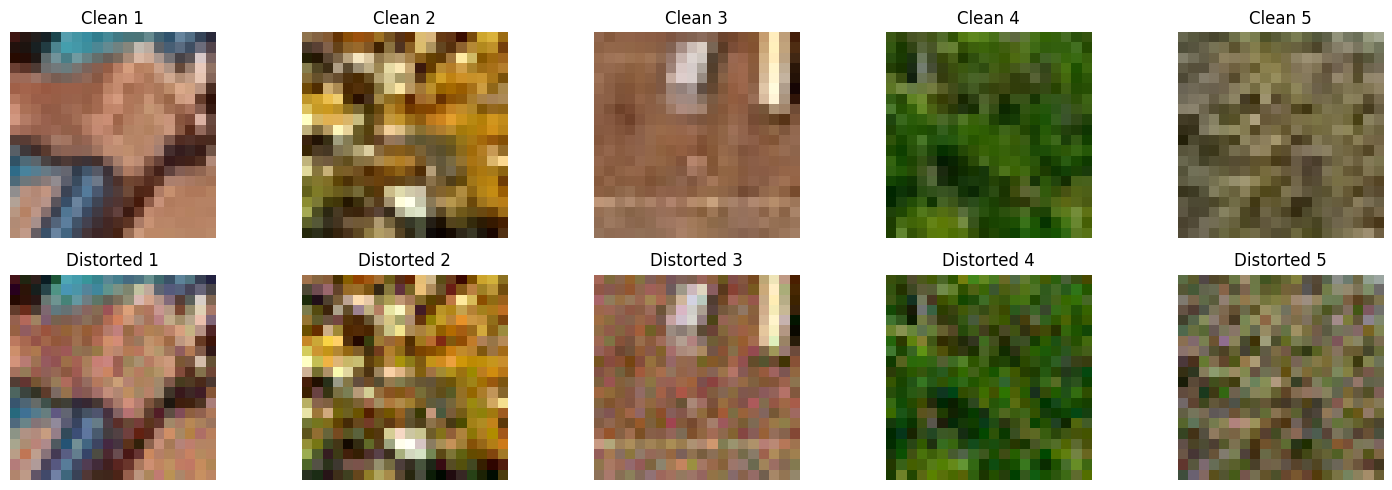

In [ ]:
# ================== DISPLAY FIRST 5 PATCHES ==================
def display_first_patches(num_samples=5):
    # Assuming the patches are named sequentially like "copy_patch_0000.png", "copy_patch_0001.png", etc.
    # and the metadata list is in the same order
    if not metadata:
        print("Metadata is empty. Please run the patch generation cell first.")
        return

    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(metadata))):
        metadata_entry = metadata[i]

        clean_img_name = metadata_entry["clean_image"]
        dist_img_name = metadata_entry["distorted_image"]
        x, y, _, _ = metadata_entry["metadata"]["roi"]

        # Load original clean and distorted images
        clean_img_path = os.path.join(REF_PATH, clean_img_name)
        dist_img_path = os.path.join(DIST_PATH, dist_img_name)

        if os.path.exists(clean_img_path) and os.path.exists(dist_img_path):
            clean_img = Image.open(clean_img_path).convert("RGB")
            dist_img = Image.open(dist_img_path).convert("RGB")

            # Extract patches using the saved coordinates
            clean_patch = extract_patch(clean_img, x, y, PATCH_SIZE)
            dist_patch = extract_patch(dist_img, x, y, PATCH_SIZE)

            # Display clean patch
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(clean_patch)
            plt.title(f"Clean {i+1}")
            plt.axis("off")

            # Display distorted patch
            plt.subplot(2, num_samples, i + num_samples + 1)
            plt.imshow(dist_patch)
            plt.title(f"Distorted {i+1}")
            plt.axis("off")
        else:
            print(f"Original images not found for metadata entry {i}")

    plt.tight_layout()
    plt.show()

display_first_patches(5)

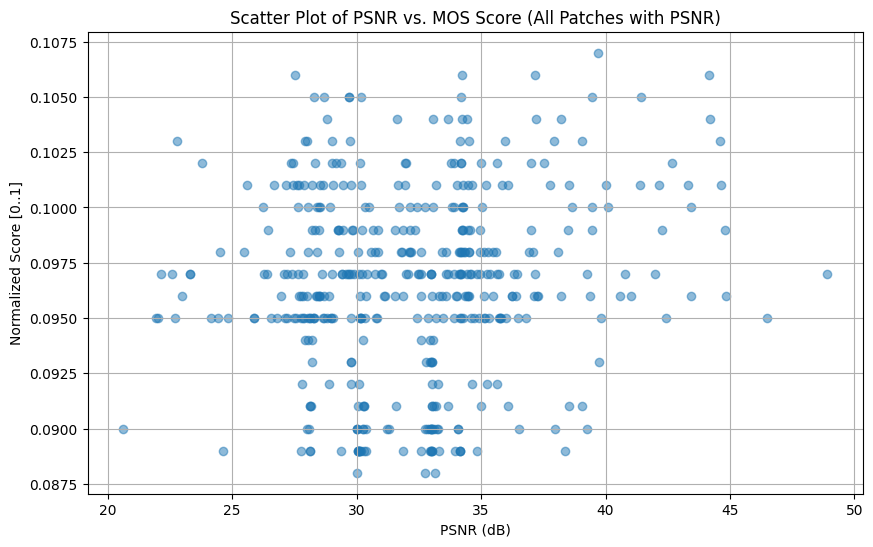

In [ ]:
# ================== DISPLAY PSNR VS. MOS SCORE SCATTER PLOT ==================

# Extract PSNR values and normalized MOS scores from metadata for all patches
# that have a 'distorted_psnr' entry in their metadata.
psnr_values_for_plot = []
mos_scores_for_plot = []

for entry in metadata:
    # Assuming 'distorted_psnr' is the relevant PSNR metric to plot against MOS
    if "distorted_psnr" in entry.get("metadata", {}):
        psnr_values_for_plot.append(entry["metadata"]["distorted_psnr"])
        mos_scores_for_plot.append(entry["score"])

# Check if there is data to plot
if psnr_values_for_plot and len(psnr_values_for_plot) == len(mos_scores_for_plot):
    plt.figure(figsize=(10, 6))
    plt.scatter(psnr_values_for_plot, mos_scores_for_plot, alpha=0.5)
    plt.xlabel("PSNR (dB)")
    plt.ylabel("Normalized Score [0..1]")
    plt.title("Scatter Plot of PSNR vs. MOS Score (All Patches with PSNR)") # Clarify title
    plt.grid(True)
    plt.show()
else:
    print("Not enough data or data size mismatch to plot PSNR vs. MOS scatter plot.")
    # Print lengths for debugging if needed
    # print(f"Length of psnr_values_for_plot: {len(psnr_values_for_plot)}")
    # print(f"Length of mos_scores_for_plot: {len(mos_scores_for_plot)}")

In [ ]:
# ================== SAVE RESULTS ==================
# Your Drive target
drive_save_dir = "/content/drive/MyDrive/Samsung_Project/jianjin008_patches"

# Ensure subfolders
copy_dir = os.path.join(drive_save_dir, "copy")
# blended_dir = os.path.join(drive_save_dir, "blended") # Directory for blended patches - No longer needed if all go to copy

# --- Clean destination directories before saving ---
print(f"Cleaning destination directory: {drive_save_dir}")
if os.path.exists(drive_save_dir):
    # Be cautious with rm -rf on Drive paths. Let's just remove the specific subdirectories we manage.
    print(f"Removing existing copy directory: {copy_dir}")
    try:
        shutil.rmtree(copy_dir)
    except FileNotFoundError:
        print(f"Directory {copy_dir} not found, skipping removal.")
    except Exception as e:
        print(f"Error removing directory {copy_dir}: {e}")

    # # Removing blended directory is no longer necessary if all go to copy
    # print(f"Removing existing blended directory: {blended_dir}")
    # try:
    #     shutil.rmtree(blended_dir)
    # except FileNotFoundError:
    #     print(f"Directory {blended_dir} not found, skipping removal.")
    # except Exception as e:
    #     print(f"Error removing directory {blended_dir}: {e}")

    # Remove known non_image_files from the main directory
    known_non_image_files = ["metadata.json", "psnr_histogram.png"]
    for fname in known_non_image_files:
        fpath = os.path.join(drive_save_dir, fname)
        if os.path.exists(fpath):
            print(f"Removing existing file: {fpath}")
            try:
                os.remove(fpath)
            except Exception as e:
                 print(f"Error removing file {fpath}: {e}")


os.makedirs(drive_save_dir, exist_ok=True) # Recreate the main directory if it was somehow removed
os.makedirs(copy_dir, exist_ok=True) # Recreate the copy directory
# os.makedirs(blended_dir, exist_ok=True) # Create the blended directory - No longer needed


def is_image(path):
    return os.path.splitext(path)[1].lower() in {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

# --- Modified saving logic ---
# Create a set of unique_sample_ids from the balanced metadata
valid_patch_uids = {entry["unique_sample_id"] for entry in metadata}

src_root = "/content/jianjin008_patches"
saved_patch_count = 0 # Counter for patches successfully saved

print(f"Copying balanced patches from local directory: {src_root}")

# Iterate through the files in the local patches directory
for root, _, files in os.walk(src_root):
    for fname in files:
        src_path = os.path.join(root, fname)
        # Check if the file is an image and its name is in the valid_patch_uids set
        if is_image(fname) and fname in valid_patch_uids:
            dst_path = os.path.join(copy_dir, fname) # Save all balanced patches to the 'copy' subdirectory
            try:
                shutil.copy2(src_path, dst_path)
                saved_patch_count += 1
            except Exception as e:
                print(f"Error copying balanced patch file {src_path} to {dst_path}: {e}")
        elif fname == "psnr_histogram.png": # Save the PSNR histogram separately
             dst_path = os.path.join(drive_save_dir, fname)
             try:
                 shutil.copy2(src_path, dst_path)
                 print(f"Saved PSNR histogram to {dst_path}")
             except Exception as e:
                  print(f"Error copying PSNR histogram {src_path} to {dst_path}: {e}")
        # Other files (like the local metadata.json which we will overwrite) are not explicitly copied here.

# --- Added conversion for JSON serialization ---
def convert_floats(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_floats(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_floats(elem) for elem in obj]
    else:
        return obj

# Convert float32 objects in metadata before saving
serializable_metadata = convert_floats(metadata)
# --- End Added conversion ---


# Save the balanced metadata to a JSON file in the main drive_save_dir
metadata_save_path = os.path.join(drive_save_dir, "metadata.json")
try:
    with open(metadata_save_path, "w") as f:
        json.dump(serializable_metadata, f, indent=2) # Use the converted metadata
    print(f"Saved balanced metadata to: {metadata_save_path}")
except Exception as e:
    print(f"Error saving metadata to {metadata_save_path}: {e}")

print(f"\nSaved balanced patches and metadata to: {drive_save_dir}")
print(f"Total balanced image files saved to copy/ subdirectory: {saved_patch_count}")


# Verify counts by listing files
try:
    print("\nSample files in copy/ directory:", sorted(os.listdir(copy_dir))[:5])
except FileNotFoundError:
    print("\nCopy directory not found after saving.")

try:
    main_dir_files = [f for f in os.listdir(drive_save_dir) if os.path.isfile(os.path.join(drive_save_dir, f))]
    print("Files in main drive_save_dir:", sorted(main_dir_files))
except FileNotFoundError:
     print("\nMain output directory not found after saving.")

# Count PNG files in copy subdirectory (should match saved_patch_count)
copy_png_count = 0
if os.path.exists(copy_dir):
    for root, _, files in os.walk(copy_dir):
        for fname in files:
            if fname.lower().endswith(".png"):
                copy_png_count += 1
    print(f"\nNumber of PNG files in {copy_dir}: {copy_png_count}")

Cleaning destination directory: /content/drive/MyDrive/Samsung_Project/jianjin008_patches
Removing existing copy directory: /content/drive/MyDrive/Samsung_Project/jianjin008_patches/copy
Removing existing file: /content/drive/MyDrive/Samsung_Project/jianjin008_patches/metadata.json
Removing existing file: /content/drive/MyDrive/Samsung_Project/jianjin008_patches/psnr_histogram.png
Copying balanced patches from local directory: /content/jianjin008_patches
Saved balanced metadata to: /content/drive/MyDrive/Samsung_Project/jianjin008_patches/metadata.json

Saved balanced patches and metadata to: /content/drive/MyDrive/Samsung_Project/jianjin008_patches
Total balanced image files saved to copy/ subdirectory: 762

Sample files in copy/ directory: ['blended_patch_1219.png', 'blended_patch_1220.png', 'blended_patch_1221.png', 'blended_patch_1222.png', 'blended_patch_1223.png']
Files in main drive_save_dir: ['blended_patch_0000.png', 'blended_patch_0001.png', 'blended_patch_0002.png', 'blended

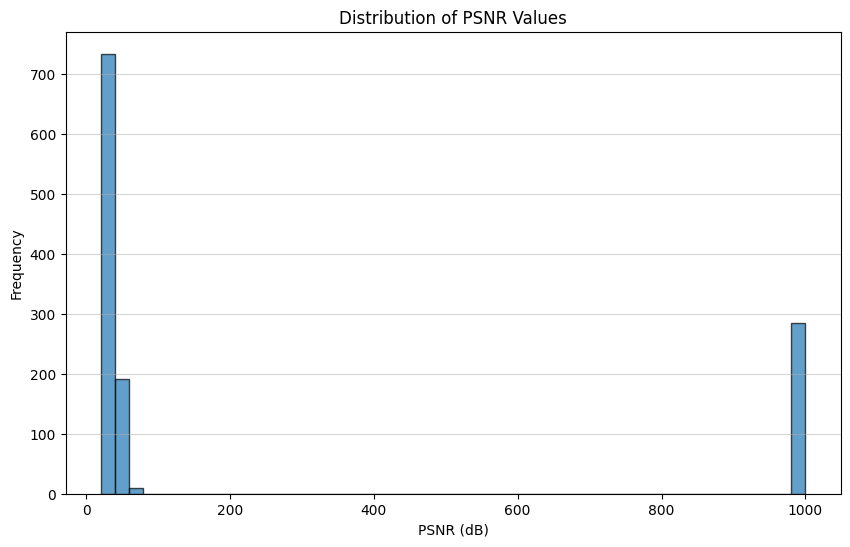

Note: 284 patches had infinite PSNR (identical to clean patch).


In [ ]:
# ================== DISPLAY PSNR HISTOGRAM ==================
import matplotlib.pyplot as plt
import numpy as np

# Filter out infinite PSNR values for the histogram, or assign a large finite value
# Infinite PSNR occurs when the images are identical (MSE is 0).
# For visualization, we can either exclude them or represent them differently.
# Let's assign a large finite value for display purposes in the histogram.
large_finite_value = 1000.0 # Choose a value larger than typical PSNRs

# Create a list of PSNR values suitable for plotting
psnr_values_for_hist = [p if np.isfinite(p) else large_finite_value for p in psnr_values]


if psnr_values_for_hist:
    plt.figure(figsize=(10, 6))
    # Use a reasonable number of bins; adjust as needed based on data distribution
    plt.hist(psnr_values_for_hist, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel("PSNR (dB)")
    plt.ylabel("Frequency")
    plt.title("Distribution of PSNR Values")
    plt.grid(True, axis='y', alpha=0.5)
    plt.show()

    # Optional: print the count of infinite PSNR values separately
    infinite_psnr_count = sum(1 for p in psnr_values if not np.isfinite(p))
    if infinite_psnr_count > 0:
        print(f"Note: {infinite_psnr_count} patches had infinite PSNR (identical to clean patch).")

else:
    print("No PSNR values available to display histogram.")

### PSNR values equal zero when MOS is identical in two images.